In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [85]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


In [86]:
print('Количество посещений сайта в группах А и B:')
display(data.groupby('group')['user_id'].agg('count'))
print('\nКоличество покупок в группах А и B:')
display(data.groupby('group')['purchase'].agg('sum'))
print('\nСумма покупок в группах А и B:')
display(data.groupby('group')['price'].agg('sum') / 1e6)

Количество посещений сайта в группах А и B:


group
A    147202
B    147276
Name: user_id, dtype: int64


Количество покупок в группах А и B:


group
A    17723
B    17514
Name: purchase, dtype: int64


Сумма покупок в группах А и B:


group
A    1436.26
B    1554.10
Name: price, dtype: float64

In [87]:
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']
user_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))
print(len(user_intersection))

1895


In [88]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

In [89]:
grouped = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum' }).rename(columns={
'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price' })
print(grouped)

       count_visits  count_purchases   sum_price
group                                           
A            145307            17487  1417780000
B            145381            17290  1533010000


#### Мы видим, что количество посещений каждой посадочной страницы сбалансировано, количество покупок туров также очень близко по группам. 

In [90]:
grouped['conversion'] = grouped['count_purchases']/grouped['count_visits'] * 100
grouped['mean_check'] = grouped['sum_price']/grouped['count_purchases']
print('Конверсия (в процентах) в группах А и B:')
display(grouped['conversion'].round(2))
print('\nСредний чек (в рублях) в группах А и B:')
display(grouped['mean_check'].round())

Конверсия (в процентах) в группах А и B:


group
A    12.03
B    11.89
Name: conversion, dtype: float64


Средний чек (в рублях) в группах А и B:


group
A    81076.0
B    88665.0
Name: mean_check, dtype: float64

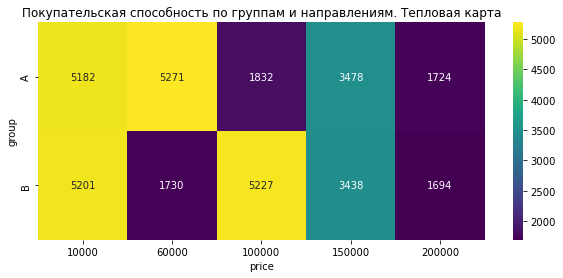

In [91]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(index='group', columns='price', values='purchase', aggfunc='sum')
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Покупательская способность по группам и направлениям. Тепловая карта');

### Покупательская способность участников группы А выше, чем у участников группы В по следующим направлениям: Турция, Камчатка и Мальдивы 

In [92]:
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits'] * 100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']

print('Конверсия 3 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2))
 
print('Средний чек 3 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'mean_check']].round())

Конверсия 3 января 2020 года:


,group,conversion
2,A,11.34
3,B,11.39


Средний чек 3 января 2020 года:


,group,mean_check
2,A,82888.0
3,B,87480.0


Кумулятивная конверсия 20 января 2020 года:


,group,cum_conversion
36,A,11.98
37,B,11.90


Кумулятивная конверсия 12 января 2020 года:


,group,cum_mean_check
20,A,81492.0
21,B,88352.0


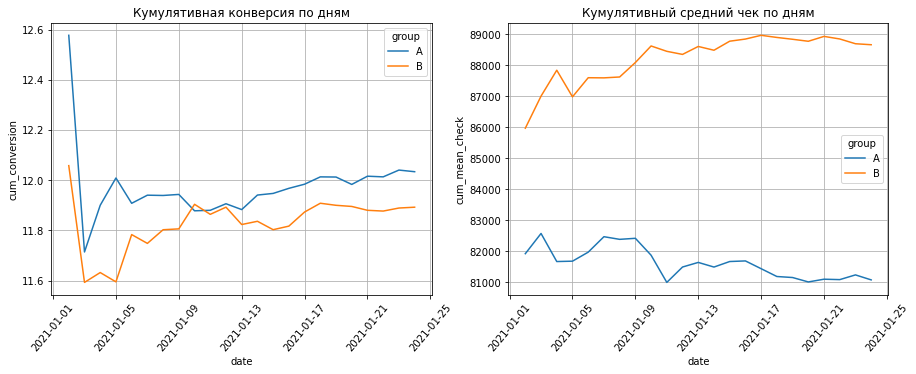

In [93]:
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum() # кумулятивное количество посещений
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum() # кумулятивное количество покупок 
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum() # кумулятивная сумма покупок
daily_data['cum_conversion'] = daily_data['cum_count_purchases']/daily_data['cum_count_visits'] * 100 # кумулятивная конверсия
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_count_purchases'] # кумулятивный средний чек
 
print('Кумулятивная конверсия 20 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conversion']].round(2))
print('Кумулятивная конверсия 12 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_mean_check']].round())
 
fig, axes= plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0]) 
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])
axes[0].set_title('Кумулятивная конверсия по дням')
axes[1].set_title('Кумулятивный средний чек по дням')
axes[0].xaxis.set_tick_params(rotation = 50)
axes[1].xaxis.set_tick_params(rotation = 50)
axes[0].grid(True);
axes[1].grid(True);

### Мы видим, что в начале конверсия принимает очень разные значения, но со временем график кумулятивной конверсии выравнивается. Кумулятивная конверсия на поздних датах уже почти напоминает прямую. Однако, для большей уверенности следовало бы продолжить эксперемент. Кумулятивный средний чек также уже больше напоминает прямую, хотя для более точных результатов можно было бы продолжить измерения. Однако уже сейчас отчетливо видно, что средний чек по группе В устойчиво и значительно превосходит средний чек в группе А. 

In [94]:
from statsmodels.stats.proportion import proportions_ztest
converted_piv= data.groupby('group')['purchase'].agg(['sum', 'count'])
display(converted_piv)
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 

_, p_value = proportions_ztest(  #p-value для z-теста для пропорций
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger')

print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,17723,147202
B,17514,147276


p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


#### Для проверки гипотезы о раверстве конверсий в группе мы выбираем Z-test, так как мы имеем дело с двумя группами, в которых более 30 объектов в выборке. При уровне значимости 0.05 мы принимаем нулевую гипотезу, так как конверсии в группах А и В равны

In [95]:
from scipy.stats import norm
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2) 

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), # размер выборки
b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff_inverval = diff_conversion_conf_interval(n, xp) # доверительный интервал для разности
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval)) 

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


#### Мы видим, что значения от 11.87 до 12.06 являются перекрытием доверительных интервалов в группах А и В.


In [96]:
from scipy.stats import shapiro
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
# тест Шапиро-Уилка
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [97]:
from scipy.stats import ttest_ind
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
# результат T-теста для выборок
results = ttest_ind(daily_data_a['mean_check'], daily_data_b['mean_check'], alternative='less')
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


#### Значение p-value ниже уровня значимости. Это значит, что мы отвергаем нулевую гипотезу и принимаем альтернативную, а именно, что средний чек в группе А меньше, чем в группе В

In [98]:
from scipy.stats import t
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
a_daily_data = daily_data[daily_data['group'] == 'A']
b_daily_data = daily_data[daily_data['group'] == 'B']
 
params_a = {
    'n': a_daily_data['count_visits'].count(), # размер выборки
    'x_mean': a_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': a_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': b_daily_data['count_visits'].count(),# размер выборки
    'x_mean': b_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': b_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


#### Мы видим, что между доверительными интервалами среднего чека группы А и группы В нет пересечений. То есть, мы можем однозначно сказать, что есть статистическая разница между группами А и В по параметру средний чек.  

#### По параметру конверсия между группами А и В нет статистической разницы. Конверсии в группах А и В равны. Однако по величине среднего чека доверительный интервал группы В превосходит доверительный интервал группы А, при чем пересечений между доверительными интервалами по величине среднего чека между группами А и В нет. То есть, участники группы В делают покупки более дорогих туров. Делаем вывод, что дизайн посадочной страницы варианта В является для нас предпочтительным.